In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/xgbregressor-model/finalized_XGBRegressor_model.pkl


In [2]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print('Size of training set is : {}\n\n'.format(df_train.shape))
display(df_train.info())
print('Size of test set is : {}\n\n'.format(df_test.shape))
display(df_test.info())

Size of training set is : (1460, 81)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-

None

Size of test set is : (1459, 80)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-nul

None

 ## 1. Handling missing values in data

### Check for columns with missing values and the count

In [4]:
null = df_train.isnull().sum()
#display(null)
null_df = pd.DataFrame({'features': null.index, 'count': null.values})
display(null_df[null_df['count'] > 0])

print('Max entries per column in the dataset is: {}'.format(df_train.shape[0]))
print('Columns with more than 50% of the data missing in the training data is \n: {}'.format(null_df[null_df['count'] > df_train.shape[0]*0.5]))
#null_df[null_df['count'] > df_train.shape[0]*0.5]

,features,count
3,LotFrontage,259
6,Alley,1369
25,MasVnrType,8
26,MasVnrArea,8
30,BsmtQual,37
31,BsmtCond,37
32,BsmtExposure,38
33,BsmtFinType1,37
35,BsmtFinType2,38
42,Electrical,1


Max entries per column in the dataset is: 1460
Columns with more than 50% of the data missing in the training data is 
:        features  count
6         Alley   1369
72       PoolQC   1453
73        Fence   1179
74  MiscFeature   1406


In [5]:
def check_null(df):
    null = df.isnull().sum()
    #display(null)
    null_df = pd.DataFrame({'features': null.index, 'count': null.values})
    return null_df[null_df['count'] > 0]

In [6]:
def check_null_50(df):
    null = df.isnull().sum()
    #display(null)
    null_df = pd.DataFrame({'features': null.index, 'count': null.values})
    return null_df[null_df['count'] > df.shape[0]*0.5]

In [7]:
print('Columns with more than 50% of the data missing in the training data are')
check_null_50(df_train)

Columns with more than 50% of the data missing in the training data are


,features,count
6,Alley,1369
72,PoolQC,1453
73,Fence,1179
74,MiscFeature,1406


In [8]:
print('Columns with more than 50% of the data missing in the test data are')
check_null_50(df_test)

Columns with more than 50% of the data missing in the test data are


,features,count
6,Alley,1352
57,FireplaceQu,730
72,PoolQC,1456
73,Fence,1169
74,MiscFeature,1408


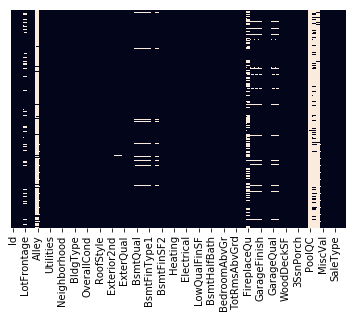

In [9]:
import seaborn as sns
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False)

In [10]:
# features to remove, which have more than 50% missing data
remove_features = null_df[null_df['count'] > df_train.shape[0]*0.5].features.tolist()
remove_features

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [11]:
# remove the columns from the train and test sets
df_train.drop(remove_features, axis=1, inplace=True)
df_test.drop(remove_features, axis=1, inplace=True)

In [12]:
# remove the 'Id'column in both train and test
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [13]:
display(df_train.shape)
display(df_test.shape)

(1460, 76)

(1459, 75)

In [14]:
#df_train.dtypes
# display(check_null(df_train))
# display(check_null(df_test))

In [15]:
#df_train[df_train.isnull().any(axis=1)]
# select the object data types
df_train_obj = df_train.select_dtypes(include=['object']).copy()

# check for missing in object type
#check_null(df_train_obj)
df_train_obj.empty

False

### Fill missing values in train and test sets
### 1. Replace all numeric features with the mean
### 2. Replace all categorical features with the mode

In [16]:
def fill_missing(df):
    df_obj = df.select_dtypes(include=['object']).copy()
    if df_obj.empty==False:
        for col in check_null(df_obj)['features'].tolist():
            df[col] = df[col].fillna(df[col].mode()[0])
    
    df_numeric = df.select_dtypes(include=['int64', 'float64']).copy()
    if df_numeric.empty==False:
        for col in check_null(df_numeric)['features'].tolist():
            df[col] = df[col].fillna(df[col].mean())

In [17]:
fill_missing(df_train)
fill_missing(df_test)

### Check for any missing values in both numeric and categorical columns

In [18]:
check_null(df_train)
check_null(df_test)

,features,count


In [19]:
# for col in check_null(df_train_obj)['features'].tolist():
#     df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

In [20]:
#df_train['FireplaceQu'].mode()[0]
# check_null(df_train)

In [21]:
# df_train_numeric = df_train.select_dtypes(include=['int64', 'float64']).copy()
# check_null(df_train_numeric)

In [22]:
# for col in check_null(df_train_numeric)['features'].tolist():
#     df_train[col] = df_train[col].fillna(df_train[col].mean())

# # check for any missing values
# check_null(df_train)

In [23]:
# df_train.info()
# print('\n\nFinal training data shape is {}'.format(df_train.shape))

In [24]:
# df_train_obj['MSZoning'].value_counts()
#df_train_obj['MSZoning']

In [25]:
#pd.get_dummies(df_train_obj['MSZoning'], drop_first=True)

### Since there can be sub-categories in test that are not in train, lets combine them together and encode them

### Combine train and test sets before encoding the categorical variables

In [26]:
# Ref: https://www.datacamp.com/community/tutorials/joining-dataframes-pandas

combined_df = pd.concat([df_train, df_test], axis=0, sort=False, keys=['train', 'test']) # row wise
combined_df

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
train 0             60       RL         65.0     8450   Pave      Reg   
      1             20       RL         80.0     9600   Pave      Reg   
      2             60       RL         68.0    11250   Pave      IR1   
      3             70       RL         60.0     9550   Pave      IR1   
      4             60       RL         84.0    14260   Pave      IR1   
...                ...      ...          ...      ...    ...      ...   
test  1454         160       RM         21.0     1936   Pave      Reg   
      1455         160       RM         21.0     1894   Pave      Reg   
      1456          20       RL        160.0    20000   Pave      Reg   
      1457          85       RL         62.0    10441   Pave      Reg   
      1458          60       RL         74.0     9627   Pave      Reg   

           LandContour Utilities LotConfig LandSlope  ... EnclosedPorch  \
train 0            Lvl    AllPub    Inside       Gtl  ...             0   
      1            Lvl    AllPub       FR2       Gtl  ...             0   
      2            Lvl    AllPub    Inside       Gtl  ...             0   
      3            Lvl    AllPub    Corner       Gtl  ...           272   
      4            Lvl    AllPub       FR2       Gtl  ...             0   
...                ...       ...       ...       ...  ...           ...   
test  1454         Lvl    AllPub    Inside       Gtl  ...             0   
      1455         Lvl    AllPub    Inside       Gtl  ...             0   
      1456         Lvl    AllPub    Inside       Gtl  ...             0   
      1457         Lvl    AllPub    Inside       Gtl  ...             0   
      1458         Lvl    AllPub    Inside       Mod  ...             0   

           3SsnPorch ScreenPorch PoolArea MiscVal  MoSold  YrSold  SaleType  \
train 0            0           0        0       0       2    2008        WD   
      1            0           0        0       0       5    2007        WD   
      2            0           0        0       0       9    2008        WD   
      3            0           0        0       0       2    2006        WD   
      4            0           0        0       0      12    2008        WD   
...              ...         ...      ...     ...     ...     ...       ...   
test  1454         0           0        0       0       6    2006        WD   
      1455         0           0        0       0       4    2006        WD   
      1456         0           0        0       0       9    2006        WD   
      1457         0           0        0     700       7    2006        WD   
      1458         0           0        0       0      11    2006        WD   

            SaleCondition SalePrice  
train 0            Normal  208500.0  
      1            Normal  181500.0  
      2            Normal  223500.0  
      3           Abnorml  140000.0  
      4            Normal  250000.0  
...                   ...       ...  
test  1454         Normal       NaN  
      1455        Abnorml       NaN  
      1456        Abnorml       NaN  
      1457         Normal       NaN  
      1458         Normal       NaN  

[2919 rows x 76 columns]

In [27]:
# to get the train and test sets back, use the 'keys'
combined_df.loc['train']
combined_df.loc['test']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,0,0,6,2010,WD,Normal,NaN
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,12500,6,2010,WD,Normal,NaN
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,WD,Normal,NaN
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2010,WD,Normal,NaN
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,0,144,0,0,1,2010,WD,Normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,NaN
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Abnorml,NaN
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2006,WD,Abnorml,NaN
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,700,7,2006,WD,Normal,NaN


### One hot encoding of the categorical variables

In [28]:
#for col in df_train_obj.columns.tolist():
# Ref: https://pbpython.com/categorical-encoding.html

# df_train_obj_ohe = pd.get_dummies(df_train_obj, columns = df_train_obj.columns.tolist())

# #df_train_obj_ohe
# # drop the columns for which we have encoded from df_train
# cat_cols_drop = df_train_obj.columns.tolist()
# df_train.drop(cat_cols_drop, axis=1, inplace=True)

# df_train_final = pd.concat([df_train, df_train_obj_ohe], axis=1)
# df_train_final

In [29]:
def cat_ohe_multcols(df):
    df_obj = df.select_dtypes(include=['object']).copy()
    columns = df_obj.columns.tolist()
    df_obj_ohe = pd.get_dummies(df, columns= columns, drop_first=True)
    return df_obj_ohe

In [30]:
final_df = cat_ohe_multcols(combined_df)
#temp = pd.concat([combined_df,onehot_df], axis=1)

# remove the duplicated columns
#final_df = temp.loc[:, ~temp.columns.duplicated()]

In [31]:
final_df['SalePrice']

train  0       208500.0
       1       181500.0
       2       223500.0
       3       140000.0
       4       250000.0
                 ...   
test   1454         NaN
       1455         NaN
       1456         NaN
       1457         NaN
       1458         NaN
Name: SalePrice, Length: 2919, dtype: float64

In [32]:
final_df.shape

(2919, 237)

In [33]:
# check for duplicate columns
np.unique(final_df.columns.duplicated())

array([False])

In [34]:
final_df

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
train 0             60         65.0     8450            7            5   
      1             20         80.0     9600            6            8   
      2             60         68.0    11250            7            5   
      3             70         60.0     9550            7            5   
      4             60         84.0    14260            8            5   
...                ...          ...      ...          ...          ...   
test  1454         160         21.0     1936            4            7   
      1455         160         21.0     1894            4            5   
      1456          20        160.0    20000            5            7   
      1457          85         62.0    10441            5            5   
      1458          60         74.0     9627            7            5   

            YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  \
train 0          2003          2003       196.0       706.0         0.0  ...   
      1          1976          1976         0.0       978.0         0.0  ...   
      2          2001          2002       162.0       486.0         0.0  ...   
      3          1915          1970         0.0       216.0         0.0  ...   
      4          2000          2000       350.0       655.0         0.0  ...   
...               ...           ...         ...         ...         ...  ...   
test  1454       1970          1970         0.0         0.0         0.0  ...   
      1455       1970          1970         0.0       252.0         0.0  ...   
      1456       1960          1996         0.0      1224.0         0.0  ...   
      1457       1992          1992         0.0       337.0         0.0  ...   
      1458       1993          1994        94.0       758.0         0.0  ...   

            SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
train 0                  0               0             0             0   
      1                  0               0             0             0   
      2                  0               0             0             0   
      3                  0               0             0             0   
      4                  0               0             0             0   
...                    ...             ...           ...           ...   
test  1454               0               0             0             0   
      1455               0               0             0             0   
      1456               0               0             0             0   
      1457               0               0             0             0   
      1458               0               0             0             0   

            SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
train 0               1                      0                     0   
      1               1                      0                     0   
      2               1                      0                     0   
      3               1                      0                     0   
      4               1                      0                     0   
...                 ...                    ...                   ...   
test  1454            1                      0                     0   
      1455            1                      0                     0   
      1456            1                      0                     0   
      1457            1                      0                     0   
      1458            1                      0                     0   

            SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
train 0                        0                     1                      0  
      1                        0                     1                      0  
      2                        0                     1                      0  
      3                        0                     0                      0  
      4 

### Now that the categorical variables have been 'ohe' get the train and test sets back

In [35]:
df_Train = final_df.loc['train']
df_Test = final_df.loc['test']

In [36]:
df_Train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [37]:
# check if there any columns of obj type
display(df_Train.info())
display(df_Test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Columns: 237 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(12), int64(25), uint8(200)
memory usage: 718.6 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Columns: 237 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(12), int64(25), uint8(200)
memory usage: 718.1 KB


None

In [38]:
#final_df.select_dtypes(include=['int64', 'float64'])

In [39]:
# drop 'SalesPrice' from df_Test, which we need to predict
df_Test.drop(['SalePrice'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
# Train
X_train = df_Train.drop(['SalePrice'], axis=1)
y_train = df_Train['SalePrice']

## Prediction using ML algorithms

### XGBoost Regressor

In [41]:
import xgboost
xgbReg = xgboost.XGBRegressor()
xgbReg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [42]:
#prediction
y_pred = xgbReg.predict(df_Test)

### Hyperparameter optimization - XGBoost Regressor

In [43]:
# XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints=None,
#              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#              min_child_weight=1, missing=nan, monotone_constraints=None,
#              n_estimators=100, n_jobs=0, num_parallel_tree=1,
#              objective='reg:squarederror', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
#              validate_parameters=False, verbosity=None)

base_score = [0.25, 0.5, 0.75, 1.0]
booster =['gbtree', 'gblinear']
gamma = [0.01, 0.001, 0.1, 0]
learning_rate = [0.05, 0.1, 0.15, 0.25, 0.3]
min_child_weight=[1, 2, 4, 6]
n_estimators= [100, 300, 500, 900, 1200, 1500]
n_jobs=-1

# define a grid of hyperparameters to tune
hyperparameter_grid = {
    'base_score': base_score,
    'booster': booster,
    'gamma': gamma,
    'learning_rate': learning_rate,
    'min_child_weight': min_child_weight,
    'n_estimators': n_estimators
    }

In [44]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=xgbReg, 
                   param_distributions= hyperparameter_grid,
                   scoring= 'neg_mean_absolute_error',
                   cv = 5,
                   n_jobs=-1,
                   n_iter=50,
                   return_train_score=True,
                   random_state=0
                  )

In [45]:
#random_cv.fit(X_train, y_train)

In [46]:
# finding the best fit
#random_cv.best_estimator_

In [47]:
# using the best fit
xgbReg = xgboost.XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=None, monotone_constraints=None,
             n_estimators=1500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [48]:
xgbReg.fit(X_train, y_train)

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [49]:
# save the mode file
import pickle
filename='finalized_XGBRegressor_model.pkl'
pickle.dump(xgbReg, open(filename, 'wb'))

In [50]:
# to load the saved model from the pickle file
#Pickled_LR_Model = pickle.load(file)
pickle.load(open('finalized_XGBRegressor_model.pkl', 'rb' ))
# or another way
with open('finalized_XGBRegressor_model.pkl', 'rb') as file:
    pickled_xgbReg_model = pickle.load(file)
pickled_xgbReg_model

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [51]:
#prediction
y_pred = xgbReg.predict(df_Test)

In [52]:
# create a sample submission
submission_temp = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
pred_df = pd.DataFrame(y_pred)
submission = pd.concat([submission_temp['Id'], pred_df], axis=1)
submission.columns=['Id', 'SalePrice']
submission.to_csv('submission.csv', index=False)

In [53]:
# find the accuracy of the training model by splitting the train into train and validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = df_Train.copy()

train, test = train_test_split(df, test_size=0.3, random_state=42)

### XGBoost Regressor

In [54]:
#train.loc[:, train.columns != 'Saleprice']

In [55]:
import xgboost
xgbReg = xgboost.XGBRegressor()
xgbReg.fit(train.loc[:, train.columns != 'SalePrice'], train['SalePrice'])
prediction = xgbReg.predict(test.loc[:, test.columns != 'SalePrice'])

print('R2 score is {}'.format(r2_score(prediction, test['SalePrice'])))
print('MSE is {}'.format(mean_squared_error(prediction, test['SalePrice'])))

R2 score is 0.8665477754289191
MSE is 772027396.5291915


In [56]:
# implement cross validation
from sklearn.model_selection import cross_val_score
X = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']
cross_val_score(xgbReg, X, y, cv=5, scoring='r2')

array([0.88232858, 0.82540454, 0.85436581, 0.89119106, 0.87059589])

In [57]:
# import sklearn
# sklearn.metrics.SCORERS

### Linear Regression Model

In [58]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X = train.loc[:, train.columns != 'SalePrice']
y = train['SalePrice']
lr.fit(X, y)
prediction = lr.predict(test.loc[:, test.columns != 'SalePrice'])
r2_score(prediction, test['SalePrice'])
#mean_squared_error(prediction, test['SalePrice'])

0.7364249824197948

In [59]:
# cross validation
X = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']
cross_val_score(lr, X, y, cv = 5, scoring='r2')

array([0.11751452, 0.8186585 , 0.8099909 , 0.8874237 , 0.67036452])

### Using Polynomial Features - testing accuracy in train/test splits on df_Train

In [60]:
# Using polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)
X_test = test.loc[:, test.columns != 'SalePrice']
X_test_ = poly.fit_transform(X_test)

# Linear regression on transformed features
lr.fit(X_, y)
prediction = lr.predict(X_test_)
r2_score(prediction, test['SalePrice'])

1.0

### we are not using the below model as it did not score well

In [61]:
# fit the model on the test set provided
#prediction_test_data = lr.predict(df_Test)

# transformation on test data
df_Test_ = poly.fit_transform(df_Test)
prediction_test = lr.predict(df_Test_)
prediction_test[:5]

array([  -30681.0197329 , -1978894.47798475,   178758.7162709 ,
         143880.39780274,   270321.14143257])

In [62]:
# # create a sample submission
# submission_temp = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
# pred_df = pd.DataFrame(prediction_test)
# submission = pd.concat([submission_temp['Id'], pred_df], axis=1)
# submission.columns=['Id', 'SalePrice']
# submission.to_csv('submission.csv', index=False)

## Implementing a Neural Network implementation

In [63]:
df_Test.values

array([[2.0000e+01, 8.0000e+01, 1.1622e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.0000e+01, 8.1000e+01, 1.4267e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.0000e+01, 7.4000e+01, 1.3830e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+01, 1.6000e+02, 2.0000e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.5000e+01, 6.2000e+01, 1.0441e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.0000e+01, 7.4000e+01, 9.6270e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [74]:
# for keras loss function

from keras import backend as kb
def keras_custom_RMSE(y_true, y_pred):
    return kb.sqrt(kb.mean(kb.square(y_true - y_pred)))

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# for different kinds of kernel initializers
# refer: https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance

model = Sequential()
model.add(Dense(units=100, kernel_initializer = 'he_uniform', activation='relu', input_dim=236))
#model.add(Dense(units=100, activation='relu', input_dim=236))
model.add(Dropout(rate=0.2))
model.add(Dense(units=100, kernel_initializer = 'he_uniform', activation='relu'))
#model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=50, kernel_initializer = 'he_uniform', activation='relu'))
#model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# compile the model
#model.compile(loss='mean_squared_error', optimizer='Adamax')

# to use 'root mean square eror', we need to define a custom function in keras, defined below
#optimizer= keras.optimizers.RMSprop(0.001)
model.compile(loss= keras_custom_RMSE, optimizer='Adam')
#model.compile(loss= keras_custom_RMSE, optimizer=optimizer)


# fit the model
# ref: https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

model.fit(X_train.values, y_train.values,\
          validation_split=0.2,\
          batch_size=16,\
          epochs = 1000)

Train on 1168 samples, validate on 292 samples
Epoch 1/1000
1168/1168 [==============================] - 0s 373us/step - loss: 123608.2493 - val_loss: 70098.8139
Epoch 2/1000
1168/1168 [==============================] - 0s 162us/step - loss: 66207.2825 - val_loss: 59160.9602
Epoch 3/1000
1168/1168 [==============================] - 0s 162us/step - loss: 56693.4690 - val_loss: 52366.8563
Epoch 4/1000
1168/1168 [==============================] - 0s 161us/step - loss: 48501.5318 - val_loss: 50242.3059
Epoch 5/1000
1168/1168 [==============================] - 0s 164us/step - loss: 44249.9953 - val_loss: 47593.6648
Epoch 6/1000
1168/1168 [==============================] - 0s 161us/step - loss: 41300.5943 - val_loss: 46224.1128
Epoch 7/1000
1168/1168 [==============================] - 0s 162us/step - loss: 42949.4904 - val_loss: 48909.9849
Epoch 8/1000
1168/1168 [==============================] - 0s 162us/step - loss: 42681.7856 - val_loss: 46169.7763
Epoch 9/1000
1168/1168 [================

Epoch 72/1000
1168/1168 [==============================] - 0s 178us/step - loss: 34902.6396 - val_loss: 43345.5960
Epoch 73/1000
1168/1168 [==============================] - 0s 173us/step - loss: 35262.2791 - val_loss: 47189.2735
Epoch 74/1000
1168/1168 [==============================] - 0s 177us/step - loss: 35260.4881 - val_loss: 44632.2064
Epoch 75/1000
1168/1168 [==============================] - 0s 173us/step - loss: 34253.9790 - val_loss: 44582.6915
Epoch 76/1000
1168/1168 [==============================] - 0s 175us/step - loss: 34210.3607 - val_loss: 43249.8744
Epoch 77/1000
1168/1168 [==============================] - 0s 177us/step - loss: 33217.6512 - val_loss: 42388.9248
Epoch 78/1000
1168/1168 [==============================] - 0s 174us/step - loss: 34028.8537 - val_loss: 42701.8616
Epoch 79/1000
1168/1168 [==============================] - 0s 173us/step - loss: 35844.3916 - val_loss: 41774.0550
Epoch 80/1000
1168/1168 [==============================] - 0s 176us/step - loss:

Epoch 143/1000
1168/1168 [==============================] - 0s 165us/step - loss: 30552.1679 - val_loss: 36840.1085
Epoch 144/1000
1168/1168 [==============================] - 0s 164us/step - loss: 29887.1790 - val_loss: 36791.2096
Epoch 145/1000
1168/1168 [==============================] - 0s 164us/step - loss: 30887.2496 - val_loss: 37559.3274
Epoch 146/1000
1168/1168 [==============================] - 0s 163us/step - loss: 28188.1501 - val_loss: 36293.4187
Epoch 147/1000
1168/1168 [==============================] - 0s 167us/step - loss: 30885.6817 - val_loss: 36704.9881
Epoch 148/1000
1168/1168 [==============================] - 0s 164us/step - loss: 29686.3874 - val_loss: 39081.0461
Epoch 149/1000
1168/1168 [==============================] - 0s 165us/step - loss: 29841.7169 - val_loss: 37854.3033
Epoch 150/1000
1168/1168 [==============================] - 0s 166us/step - loss: 29775.0784 - val_loss: 35889.2525
Epoch 151/1000
1168/1168 [==============================] - 0s 162us/ste

1168/1168 [==============================] - 0s 164us/step - loss: 27546.1957 - val_loss: 33926.2212
Epoch 214/1000
1168/1168 [==============================] - 0s 177us/step - loss: 28849.0906 - val_loss: 32711.9738
Epoch 215/1000
1168/1168 [==============================] - 0s 161us/step - loss: 28104.1652 - val_loss: 33759.7333
Epoch 216/1000
1168/1168 [==============================] - 0s 162us/step - loss: 28291.9711 - val_loss: 34494.7025
Epoch 217/1000
1168/1168 [==============================] - 0s 162us/step - loss: 27979.8055 - val_loss: 33655.1730
Epoch 218/1000
1168/1168 [==============================] - 0s 167us/step - loss: 27408.6071 - val_loss: 39130.9443
Epoch 219/1000
1168/1168 [==============================] - 0s 166us/step - loss: 26208.0754 - val_loss: 33665.6227
Epoch 220/1000
1168/1168 [==============================] - 0s 163us/step - loss: 30218.2339 - val_loss: 33947.7007
Epoch 221/1000
1168/1168 [==============================] - 0s 163us/step - loss: 26931

Epoch 284/1000
1168/1168 [==============================] - 0s 158us/step - loss: 26793.9033 - val_loss: 34890.6872
Epoch 285/1000
1168/1168 [==============================] - 0s 159us/step - loss: 28750.3856 - val_loss: 32118.1480
Epoch 286/1000
1168/1168 [==============================] - 0s 160us/step - loss: 26548.1834 - val_loss: 32745.6834
Epoch 287/1000
1168/1168 [==============================] - 0s 158us/step - loss: 26467.1413 - val_loss: 33730.8057
Epoch 288/1000
1168/1168 [==============================] - 0s 158us/step - loss: 28817.4122 - val_loss: 35332.8043
Epoch 289/1000
1168/1168 [==============================] - 0s 159us/step - loss: 25880.7991 - val_loss: 32119.4129
Epoch 290/1000
1168/1168 [==============================] - 0s 158us/step - loss: 27002.3381 - val_loss: 31528.9823
Epoch 291/1000
1168/1168 [==============================] - 0s 161us/step - loss: 26496.7043 - val_loss: 32356.7593
Epoch 292/1000
1168/1168 [==============================] - 0s 160us/ste

1168/1168 [==============================] - 0s 166us/step - loss: 25565.6948 - val_loss: 30021.9041
Epoch 355/1000
1168/1168 [==============================] - 0s 163us/step - loss: 25656.6243 - val_loss: 33425.6330
Epoch 356/1000
1168/1168 [==============================] - 0s 165us/step - loss: 24231.4012 - val_loss: 30340.2071
Epoch 357/1000
1168/1168 [==============================] - 0s 164us/step - loss: 24681.7513 - val_loss: 31224.4815
Epoch 358/1000
1168/1168 [==============================] - 0s 164us/step - loss: 24658.9385 - val_loss: 31917.7159
Epoch 359/1000
1168/1168 [==============================] - 0s 163us/step - loss: 24992.9173 - val_loss: 30757.1635
Epoch 360/1000
1168/1168 [==============================] - 0s 162us/step - loss: 25047.8374 - val_loss: 31336.9531
Epoch 361/1000
1168/1168 [==============================] - 0s 162us/step - loss: 26029.4021 - val_loss: 31594.2446
Epoch 362/1000
1168/1168 [==============================] - 0s 163us/step - loss: 24573

Epoch 425/1000
1168/1168 [==============================] - 0s 163us/step - loss: 24085.9058 - val_loss: 29304.7776
Epoch 426/1000
1168/1168 [==============================] - 0s 166us/step - loss: 25180.8224 - val_loss: 32424.1285
Epoch 427/1000
1168/1168 [==============================] - 0s 169us/step - loss: 25410.6638 - val_loss: 29242.7705
Epoch 428/1000
1168/1168 [==============================] - 0s 172us/step - loss: 23740.0224 - val_loss: 29435.1274
Epoch 429/1000
1168/1168 [==============================] - 0s 180us/step - loss: 23625.0413 - val_loss: 29085.2892
Epoch 430/1000
1168/1168 [==============================] - 0s 217us/step - loss: 25731.5775 - val_loss: 28357.1992
Epoch 431/1000
1168/1168 [==============================] - 0s 166us/step - loss: 23568.7230 - val_loss: 30104.5373
Epoch 432/1000
1168/1168 [==============================] - 0s 162us/step - loss: 23256.3567 - val_loss: 29946.5566
Epoch 433/1000
1168/1168 [==============================] - 0s 162us/ste

1168/1168 [==============================] - 0s 167us/step - loss: 22800.8863 - val_loss: 31271.8040
Epoch 496/1000
1168/1168 [==============================] - 0s 166us/step - loss: 23330.4871 - val_loss: 29994.5468
Epoch 497/1000
1168/1168 [==============================] - 0s 168us/step - loss: 23267.2170 - val_loss: 30651.0756
Epoch 498/1000
1168/1168 [==============================] - 0s 169us/step - loss: 26447.3989 - val_loss: 29986.6469
Epoch 499/1000
1168/1168 [==============================] - 0s 165us/step - loss: 23847.7500 - val_loss: 29089.9052
Epoch 500/1000
1168/1168 [==============================] - 0s 166us/step - loss: 24352.1519 - val_loss: 30789.7694
Epoch 501/1000
1168/1168 [==============================] - 0s 163us/step - loss: 23077.6229 - val_loss: 30187.1983
Epoch 502/1000
1168/1168 [==============================] - 0s 166us/step - loss: 24994.8560 - val_loss: 28517.5304
Epoch 503/1000
1168/1168 [==============================] - 0s 164us/step - loss: 22464

Epoch 566/1000
1168/1168 [==============================] - 0s 164us/step - loss: 23944.8915 - val_loss: 27057.3910
Epoch 567/1000
1168/1168 [==============================] - 0s 159us/step - loss: 23299.7947 - val_loss: 28086.3202
Epoch 568/1000
1168/1168 [==============================] - 0s 159us/step - loss: 23085.0926 - val_loss: 27972.8147
Epoch 569/1000
1168/1168 [==============================] - 0s 158us/step - loss: 22749.0178 - val_loss: 28306.9807
Epoch 570/1000
1168/1168 [==============================] - 0s 161us/step - loss: 23156.6533 - val_loss: 37445.3566
Epoch 571/1000
1168/1168 [==============================] - 0s 164us/step - loss: 23969.6967 - val_loss: 27321.9942
Epoch 572/1000
1168/1168 [==============================] - 0s 162us/step - loss: 23377.7483 - val_loss: 29314.2651
Epoch 573/1000
1168/1168 [==============================] - 0s 163us/step - loss: 24754.7118 - val_loss: 30468.1256
Epoch 574/1000
1168/1168 [==============================] - 0s 163us/ste

1168/1168 [==============================] - 0s 166us/step - loss: 23492.2009 - val_loss: 27768.9455
Epoch 637/1000
1168/1168 [==============================] - 0s 163us/step - loss: 22215.4032 - val_loss: 28579.4879
Epoch 638/1000
1168/1168 [==============================] - 0s 165us/step - loss: 21903.4788 - val_loss: 28760.9582
Epoch 639/1000
1168/1168 [==============================] - 0s 163us/step - loss: 22972.3471 - val_loss: 28094.7128
Epoch 640/1000
1168/1168 [==============================] - 0s 163us/step - loss: 21658.8607 - val_loss: 28286.5448
Epoch 641/1000
1168/1168 [==============================] - 0s 160us/step - loss: 22209.9854 - val_loss: 29138.8063
Epoch 642/1000
1168/1168 [==============================] - 0s 165us/step - loss: 22135.7852 - val_loss: 29616.4720
Epoch 643/1000
1168/1168 [==============================] - 0s 162us/step - loss: 23145.5011 - val_loss: 28516.9458
Epoch 644/1000
1168/1168 [==============================] - 0s 162us/step - loss: 22906

Epoch 707/1000
1168/1168 [==============================] - 0s 172us/step - loss: 22347.2272 - val_loss: 29306.5927
Epoch 708/1000
1168/1168 [==============================] - 0s 163us/step - loss: 21851.0268 - val_loss: 28101.0200
Epoch 709/1000
1168/1168 [==============================] - 0s 165us/step - loss: 21630.9247 - val_loss: 28884.4833
Epoch 710/1000
1168/1168 [==============================] - 0s 169us/step - loss: 23748.1586 - val_loss: 28412.2521
Epoch 711/1000
1168/1168 [==============================] - 0s 171us/step - loss: 21844.1120 - val_loss: 28511.1180
Epoch 712/1000
1168/1168 [==============================] - 0s 166us/step - loss: 24477.0286 - val_loss: 28615.0383
Epoch 713/1000
1168/1168 [==============================] - 0s 171us/step - loss: 22541.4651 - val_loss: 29558.6249
Epoch 714/1000
1168/1168 [==============================] - 0s 169us/step - loss: 22804.1551 - val_loss: 27474.6565
Epoch 715/1000
1168/1168 [==============================] - 0s 167us/ste

1168/1168 [==============================] - 0s 168us/step - loss: 21661.4170 - val_loss: 29184.5241
Epoch 778/1000
1168/1168 [==============================] - 0s 168us/step - loss: 21826.6666 - val_loss: 28992.5694
Epoch 779/1000
1168/1168 [==============================] - 0s 177us/step - loss: 21923.8781 - val_loss: 28011.2793
Epoch 780/1000
1168/1168 [==============================] - 0s 164us/step - loss: 20722.5920 - val_loss: 31713.8045
Epoch 781/1000
1168/1168 [==============================] - 0s 162us/step - loss: 22007.9082 - val_loss: 30870.2618
Epoch 782/1000
1168/1168 [==============================] - 0s 167us/step - loss: 22107.5070 - val_loss: 27770.3595
Epoch 783/1000
1168/1168 [==============================] - 0s 163us/step - loss: 21953.1205 - val_loss: 32104.9615
Epoch 784/1000
1168/1168 [==============================] - 0s 163us/step - loss: 21632.1359 - val_loss: 32769.9938
Epoch 785/1000
1168/1168 [==============================] - 0s 164us/step - loss: 23532

Epoch 848/1000
1168/1168 [==============================] - 0s 171us/step - loss: 23014.2685 - val_loss: 30838.8066
Epoch 849/1000
1168/1168 [==============================] - 0s 173us/step - loss: 20869.9667 - val_loss: 31557.2426
Epoch 850/1000
1168/1168 [==============================] - 0s 175us/step - loss: 21446.3679 - val_loss: 29263.9494
Epoch 851/1000
1168/1168 [==============================] - 0s 171us/step - loss: 20888.6032 - val_loss: 28671.2999
Epoch 852/1000
1168/1168 [==============================] - 0s 171us/step - loss: 22879.8661 - val_loss: 27821.9155
Epoch 853/1000
1168/1168 [==============================] - 0s 170us/step - loss: 21509.3283 - val_loss: 30259.8077
Epoch 854/1000
1168/1168 [==============================] - 0s 171us/step - loss: 21581.9325 - val_loss: 30131.3059
Epoch 855/1000
1168/1168 [==============================] - 0s 179us/step - loss: 21274.8280 - val_loss: 29423.6324
Epoch 856/1000
1168/1168 [==============================] - 0s 171us/ste

1168/1168 [==============================] - 0s 163us/step - loss: 20573.6032 - val_loss: 31643.9013
Epoch 919/1000
1168/1168 [==============================] - 0s 165us/step - loss: 21181.2696 - val_loss: 31733.1148
Epoch 920/1000
1168/1168 [==============================] - 0s 164us/step - loss: 21069.6674 - val_loss: 32733.1035
Epoch 921/1000
1168/1168 [==============================] - 0s 168us/step - loss: 20023.2713 - val_loss: 29308.8703
Epoch 922/1000
1168/1168 [==============================] - 0s 165us/step - loss: 21165.8572 - val_loss: 33488.6841
Epoch 923/1000
1168/1168 [==============================] - 0s 164us/step - loss: 20172.2303 - val_loss: 35266.1714
Epoch 924/1000
1168/1168 [==============================] - 0s 163us/step - loss: 19932.1202 - val_loss: 33336.1410
Epoch 925/1000
1168/1168 [==============================] - 0s 165us/step - loss: 20291.2492 - val_loss: 29317.2964
Epoch 926/1000
1168/1168 [==============================] - 0s 163us/step - loss: 20959

Epoch 989/1000
1168/1168 [==============================] - 0s 163us/step - loss: 19818.7580 - val_loss: 37761.9894
Epoch 990/1000
1168/1168 [==============================] - 0s 163us/step - loss: 19615.8455 - val_loss: 35672.1401
Epoch 991/1000
1168/1168 [==============================] - 0s 161us/step - loss: 20214.8242 - val_loss: 33797.5461
Epoch 992/1000
1168/1168 [==============================] - 0s 164us/step - loss: 19675.9373 - val_loss: 36960.0447
Epoch 993/1000
1168/1168 [==============================] - 0s 167us/step - loss: 19480.9640 - val_loss: 35384.9866
Epoch 994/1000
1168/1168 [==============================] - 0s 169us/step - loss: 19741.3087 - val_loss: 35464.9955
Epoch 995/1000
1168/1168 [==============================] - 0s 164us/step - loss: 20974.1735 - val_loss: 33360.6795
Epoch 996/1000
1168/1168 [==============================] - 0s 162us/step - loss: 21163.4391 - val_loss: 31317.2824
Epoch 997/1000
1168/1168 [==============================] - 0s 163us/ste

In [76]:
# saving the keras model to a pickle file
import pickle
filename = 'keras_DL_model.pkl'
pickle.dump(model , open(filename, 'wb'))

In [77]:
# prediction using NN
prediction_nn = model.predict(df_Test)

In [78]:
#submission
# create a sample submission
submission_temp = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
pred_df = pd.DataFrame(prediction_nn)
submission = pd.concat([submission_temp['Id'], pred_df], axis=1)
submission.columns=['Id', 'SalePrice']
submission.to_csv('submission.csv', index=False)